In [1]:
from utils import load_cnf, cnf_to_bqm
from embedding_utils import *
import seaborn as sns
from redundancy import *
from utils import *
from dwave.embedding.chain_strength import scaled

In [2]:
folder = 'sat'
_variables = 140
path = f"./{folder}/sgen1-{folder}-{_variables}-100.cnf"
num_variables, num_clauses, variables, clauses = load_cnf(path)
bqm, or_result_vars, clauses_qubits, _ = cnf_to_bqm(variables, clauses)

In [3]:
cnf_result = "-1 -2 3 -4 -5 6 -7 -8 -9 -10 -11 12 -13 -14 -15 -16 -17 18 -19 -20 -21 -22 23 -24 -25 -26 27 -28 -29 -30 -31 32 -33 -34 -35 36 -37 -38 -39 -40 41 -42 -43 -44 -45 -46 -47 -48 49 -50 51 -52 -53 -54 -55 -56 -57 -58 59 -60 61 -62 -63 -64 -65 -66 -67 68 -69 -70 71 -72 -73 -74 -75 -76 -77 78 -79 -80 -81 -82 -83 84 -85 -86 87 -88 -89 -90 -91 -92 -93 94 -95 -96 -97 -98 99 -100 -101 -102 -103 104 -105 -106 107 -108 -109 -110 -111 -112 113 -114 -115 116 -117 -118 -119 -120 -121 -122 -123 124 -125 -126 -127 128 -129 -130 -131 -132 133 -134 -135 136 -137 -138 -139 -140 0".split(" ")
answer = dict()
for x in cnf_result[:-1]:
    int_x = int(x)
    answer[abs(int_x)] = int(int_x > 0)
evaluate_cnf_formula(answer, or_result_vars, bqm)

0.0

In [4]:
len(bqm.adj)

140

In [5]:
# check that clauses of length 5 have only one bit==true
for clause in clauses:
    line = ""
    true_bits = 0
    for var in clause:
        line += f" {answer[abs(var)]}"
        if answer[abs(var)] == 1:
            true_bits +=1
    if len(clause) == 5:
        assert(true_bits == 1)

In [27]:
from minorminer import busclique
import dwave_networkx as dnx
embedding = busclique.find_clique_embedding(140, dnx.pegasus_graph(16), seed=1)

<AxesSubplot:ylabel='Count'>

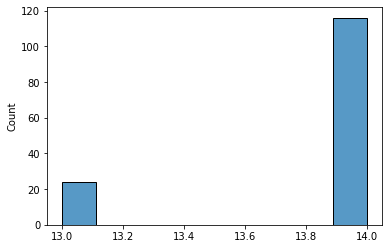

In [28]:
chain_lengths = []
for (key, chain) in embedding.items():
    chain_lengths.append(len(chain))
sns.histplot(chain_lengths)